<a href="https://colab.research.google.com/github/SteveWong-a/COSMOS-ratplacecelldata/blob/main/ratVS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# In your Jupyter Notebook cell
import scipy.io
import numpy as np

# --- Load the .mat file ---
# IMPORTANT: Replace this with the actual path to your file
file_path = "/Users/stevew/Projects/COSMOS/data/COSMO_data_openfield_IMG10_0713.mat"

try:
    mat_data = scipy.io.loadmat(file_path)
    cosmos_data = mat_data['COSMO_data']
    print("✅ Successfully loaded the .mat file!")

    # Extract field names
    field_names = cosmos_data.dtype.names
    print(f"Fields found in COSMO_data: {field_names}")

except FileNotFoundError:
    print(f"❌ Error: The file was not found at '{file_path}'")
except Exception as e:
    print(f"An error occurred: {e}")

✅ Successfully loaded the .mat file!
Fields found in COSMO_data: ('timestamps', 'calcium_signal', 'coordinates', 'head_orientation', 'segment_time')


In [ ]:
import pandas as pd
import numpy as np
from IPython.display import display

# --- 1. Extract data arrays from the struct ---
try:
    calcium_signal = cosmos_data[0, 0]['calcium_signal']
    coordinates = cosmos_data[0, 0]['coordinates']
    head_orientation = np.squeeze(cosmos_data[0, 0]['head_orientation'])
    timestamps = np.squeeze(cosmos_data[0, 0]['timestamps'])
    print("✅ Successfully extracted data arrays.")
except KeyError as e:
    print(f"❌ Error: A required field was not found: {e}")


# --- 2. Calculate all motion variables ---
delta_time = np.diff(timestamps)
delta_position = np.diff(coordinates, axis=0)
velocity = delta_position / delta_time[:, np.newaxis]
speed = np.linalg.norm(velocity, axis=1)
delta_theta = np.diff(head_orientation)
delta_theta_corrected = (delta_theta + np.pi) % (2 * np.pi) - np.pi
angular_velocity = delta_theta_corrected / delta_time


# --- 3. Build the initial DataFrame ---
data_dict = {
    'timestamp': timestamps[1:],
    'x_position': coordinates[1:, 0],
    'y_position': coordinates[1:, 1],
    'head_orientation': head_orientation[1:],
    'velocity_x': velocity[:, 0],
    'velocity_y': velocity[:, 1],
    'speed': speed,
    'angular_velocity': angular_velocity,
    'calcium_signal': [row for row in calcium_signal[1:, :]]
}
df_motion = pd.DataFrame(data_dict)


# --- 4. Filter for significant angular velocity ---
print(f"\nOriginal number of data points: {len(df_motion)}")
angular_velocity_threshold = 0.002
is_turning = (df_motion['angular_velocity'] > angular_velocity_threshold) | \
             (df_motion['angular_velocity'] < -angular_velocity_threshold)

# Create the final filtered DataFrame containing only turns
df_turning = df_motion[is_turning].copy() # Use .copy() to avoid SettingWithCopyWarning

print(f"Number of data points after filtering for turns: {len(df_turning)}")


# --- 5. Display the results ---
print("\n--- Filtered DataFrame Info ---")
df_turning.info()

print("\n--- Filtered DataFrame Head ('df_turning') ---")
display(df_turning.head())

✅ Successfully extracted data arrays.

Original number of data points: 14277
Number of data points after filtering for turns: 2539

--- Filtered DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 2539 entries, 0 to 14276
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestamp         2539 non-null   float64
 1   x_position        2539 non-null   float64
 2   y_position        2539 non-null   float64
 3   head_orientation  2539 non-null   float64
 4   velocity_x        2539 non-null   float64
 5   velocity_y        2539 non-null   float64
 6   speed             2539 non-null   float64
 7   angular_velocity  2539 non-null   float64
 8   calcium_signal    2539 non-null   object 
dtypes: float64(8), object(1)
memory usage: 198.4+ KB

--- Filtered DataFrame Head ('df_turning') ---


,timestamp,x_position,y_position,head_orientation,velocity_x,velocity_y,speed,angular_velocity,calcium_signal
0,126.666667,269.429310,191.024720,-1.917600,0.099392,-0.009849,0.099879,-0.004292,"[0.0, 0.05035325818116775, 0.25815726824684043..."
1,227.833333,270.186106,201.640002,-2.484888,0.007481,0.104929,0.105195,-0.005607,"[0.0, 0.04415835386266466, 0.31128298842365515..."
3,430.333333,357.215369,255.448136,-2.312756,0.840642,0.466873,0.961587,0.003291,"[0.0, 0.03396122789791483, 0.2882744862451742,..."
4,531.333333,415.770237,295.129446,-1.976344,0.579751,0.392884,0.700335,0.003331,"[0.0, 0.029783014797086737, 0.2935375215216078..."
5,632.666667,267.992801,233.413497,-1.657905,-1.458330,-0.609039,1.580397,0.003142,"[0.0, 0.02611884117771564, 0.4718304327862518,..."


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd


# --- Use the DataFrame created previously ---
# Ensure 'df_corrected' is available from the previous step

# 1. Prepare the features (X)
# We need to stack the vectors from the 'calcium_signal' column into a 2D numpy array
X = np.stack(df_corrected['calcium_signal'].values)

# 2. Prepare the circular targets (y)
# Transform the single angle into two continuous values (cos, sin)
head_orientation = df_corrected['head_orientation'].values
y_cos = np.cos(head_orientation)
y_sin = np.sin(head_orientation)

# Combine them into a single target array of shape (n_samples, 2)
y = np.stack([y_cos, y_sin], axis=1)

print(f"Shape of input features (X): {X.shape}")
print(f"Shape of target features (y): {y.shape}")


# 3. Split and scale the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale input features
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

# --- Convert to PyTorch Tensors ---
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# --- Create DataLoaders ---
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Shape of input features (X): (14277, 168)
Shape of target features (y): (14277, 2)


/Users/stevew/.pyenv/versions/3.10.11/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/stevew/.pyenv/versions/3.10.11/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/stevew/.pyenv/versions/3.10.11/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# --- Recreate the initial data ---
calcium_signal = cosmos_data[0, 0]['calcium_signal']
head_orientation = np.squeeze(cosmos_data[0, 0]['head_orientation'])
timestamps = np.squeeze(cosmos_data[0, 0]['timestamps'])

delta_time = np.diff(timestamps)
delta_theta = np.diff(head_orientation)
angular_velocity = (delta_theta + np.pi) % (2 * np.pi) - np.pi
angular_velocity = angular_velocity / delta_time

X = calcium_signal[:-1, :]
y = angular_velocity

# --- Split the data BEFORE scaling ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Scale features ---
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

# --- FIX: Find and remove NaN columns created by the scaler ---
# Find columns in the training set that are all NaN
nan_cols = np.all(np.isnan(X_train_scaled), axis=0)
nan_indices = np.where(nan_cols)[0]

if len(nan_indices) > 0:
    print(f"⚠️ Found {len(nan_indices)} columns with NaN values after scaling. Removing them.")
    print(f"   Column indices to remove: {nan_indices}")
    # Remove the problematic columns from both training and testing sets
    X_train_scaled = np.delete(X_train_scaled, nan_indices, axis=1)
    X_test_scaled = np.delete(X_test_scaled, nan_indices, axis=1)
else:
    print("✅ No NaN values found after scaling. Data is clean.")


# --- Scale the target variable ---
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

# --- Convert to PyTorch Tensors ---
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# --- Create DataLoaders ---
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"\nData is now clean and ready for model training.")
print(f"Final shape of training features: {X_train_tensor.shape}")

⚠️ Found 3 columns with NaN values after scaling. Removing them.
   Column indices to remove: [78 80 89]

Data is now clean and ready for model training.
Final shape of training features: torch.Size([11421, 165])


/Users/stevew/.pyenv/versions/3.10.11/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/stevew/.pyenv/versions/3.10.11/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/stevew/.pyenv/versions/3.10.11/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Prepare Data for Head Orientation Prediction ---

# Extract the base arrays from the loaded MATLAB struct
calcium_signal = cosmos_data[0, 0]['calcium_signal']
head_orientation = np.squeeze(cosmos_data[0, 0]['head_orientation'])
X = calcium_signal

# Create the 2-dimensional target (y) from head_orientation
y = np.stack([np.cos(head_orientation), np.sin(head_orientation)], axis=1)

# --- 2. Split and Scale Data with NaN Imputation ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the scaler on the training data
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

# --- THE FIX: Impute any NaNs created by the scaler ---
# Replace any NaN values with 0. This is a robust way to handle scaling artifacts.
if np.isnan(X_train_scaled).any():
    print("⚠️ NaNs found after scaling. Imputing with 0.")
    X_train_scaled = np.nan_to_num(X_train_scaled)
    X_test_scaled = np.nan_to_num(X_test_scaled)
else:
    print("✅ No NaN values found after scaling. Data is clean.")

# The target y does not need scaling as it's already in a [-1, 1] range.

# --- 3. Prepare Data for PyTorch ---
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# --- 4. Define, Train, and Evaluate the PyTorch Model ---
class StableCircularMLP(nn.Module):
    def __init__(self, input_size):
        super(StableCircularMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2),
            nn.Tanh()
        )
    def forward(self, x):
        return self.layers(x)

# Initialize
input_size = X_train_scaled.shape[1]
model = StableCircularMLP(input_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Training Loop
epochs = 100
print("\n🚀 Starting model training...")
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = loss_function(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
print("✅ Training complete.")

# Evaluation
model.eval()
with torch.no_grad():
    predictions_xy = model(X_test_tensor)
    predicted_angles = torch.atan2(predictions_xy[:, 1], predictions_xy[:, 0])
    true_angles = torch.atan2(y_test_tensor[:, 1], y_test_tensor[:, 0])

    diff = true_angles - predicted_angles
    angular_error = torch.atan2(torch.sin(diff), torch.cos(diff))
    mean_error_rad = torch.mean(torch.abs(angular_error))
    mean_error_deg = torch.rad2deg(mean_error_rad)
    print(f"\nModel Performance on Test Data:")
    print(f"Mean Absolute Angular Error: {mean_error_rad:.3f} radians (~{mean_error_deg:.1f} degrees)")

⚠️ NaNs found after scaling. Imputing with 0.

🚀 Starting model training...


/Users/stevew/.pyenv/versions/3.10.11/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/stevew/.pyenv/versions/3.10.11/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/stevew/.pyenv/versions/3.10.11/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Epoch [10/100], Loss: 0.2354
Epoch [20/100], Loss: 0.1290
Epoch [30/100], Loss: 0.1289
Epoch [40/100], Loss: 0.0787
Epoch [50/100], Loss: 0.0677
Epoch [60/100], Loss: 0.1065
Epoch [70/100], Loss: 0.0484
Epoch [80/100], Loss: 0.1247
Epoch [90/100], Loss: 0.0710
Epoch [100/100], Loss: 0.0624
✅ Training complete.

Model Performance on Test Data:
Mean Absolute Angular Error: 0.224 radians (~12.8 degrees)


In [ ]:
# Add this to your notebook after training the 'StableCircularMLP'
torch.save(model.state_dict(), 'orientation_model.pth')
print("✅ Model weights saved to orientation_model.pth")

✅ Model weights saved to orientation_model.pth


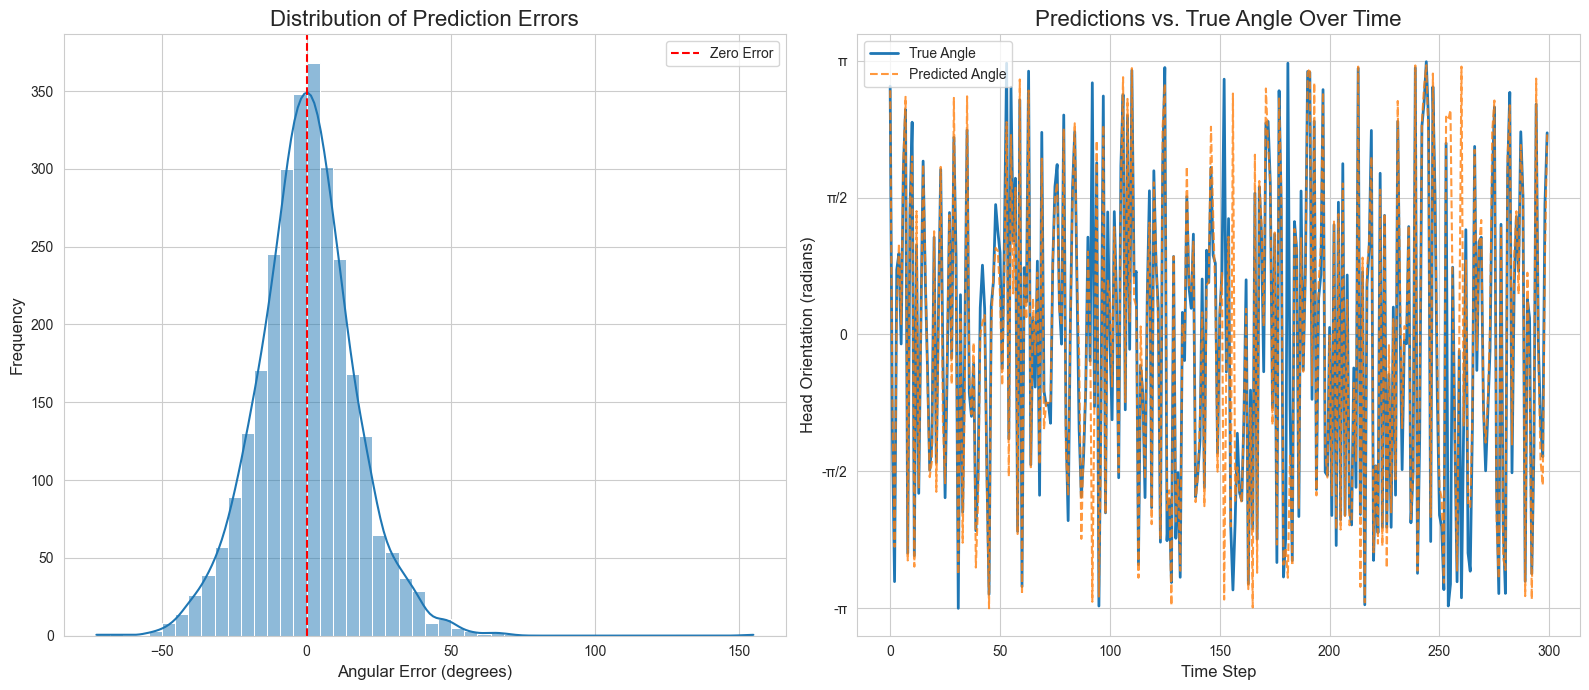

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# This cell assumes the 'model' and the test tensors
# (X_test_tensor, y_test_tensor) from the previous step are available.

# --- 1. Generate Predictions and Errors ---
model.eval()
with torch.no_grad():
    predictions_xy = model(X_test_tensor)
    predicted_angles = torch.atan2(predictions_xy[:, 1], predictions_xy[:, 0])
    true_angles = torch.atan2(y_test_tensor[:, 1], y_test_tensor[:, 0])

    # Calculate the angular error, correctly handling the wrap-around
    diff = true_angles - predicted_angles
    angular_error_rad = torch.atan2(torch.sin(diff), torch.cos(diff))
    angular_error_deg = torch.rad2deg(angular_error_rad).numpy()


# --- 2. Create the Visualizations ---

# Set a plotting style
sns.set_style("whitegrid")
plt.figure(figsize=(16, 7))

# Plot 1: Histogram of Angular Errors
plt.subplot(1, 2, 1)
sns.histplot(angular_error_deg, bins=50, kde=True)
plt.title('Distribution of Prediction Errors', fontsize=16)
plt.xlabel('Angular Error (degrees)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
plt.legend()


# Plot 2: Predictions Over a Time Segment
plt.subplot(1, 2, 2)
# Let's plot the first 300 time points of the test set
time_slice = slice(0, 300)
time_axis = np.arange(300)

plt.plot(time_axis, true_angles.numpy()[time_slice], label='True Angle', linewidth=2)
plt.plot(time_axis, predicted_angles.numpy()[time_slice], label='Predicted Angle', linestyle='--', alpha=0.8)
plt.title('Predictions vs. True Angle Over Time', fontsize=16)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Head Orientation (radians)', fontsize=12)
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['-π', '-π/2', '0', 'π/2', 'π'])
plt.legend()


plt.tight_layout()
plt.show()

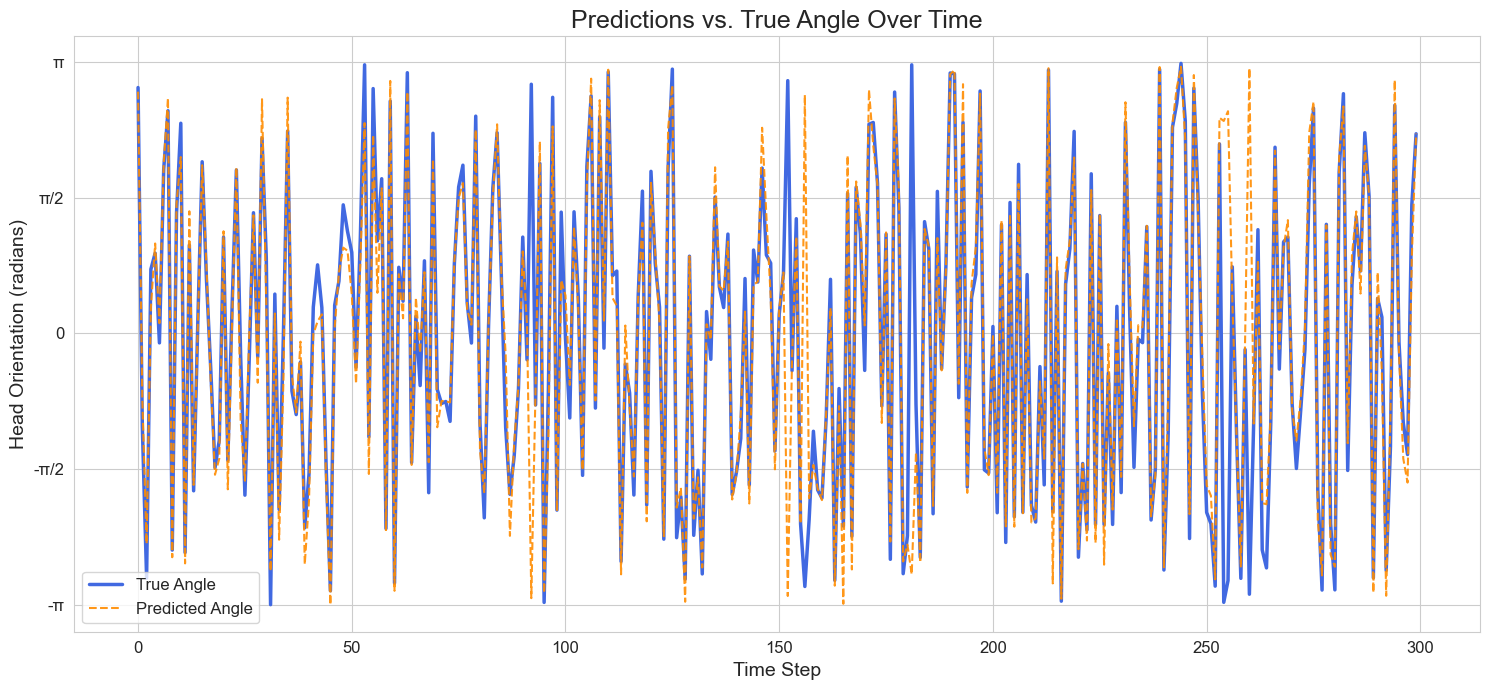

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# This cell assumes the 'model' and the 'X_test_tensor', 'y_test_tensor'
# from the previous training step are available.

# --- 1. Generate Predictions and Errors ---
# We regenerate the predictions here to make this cell self-contained.
model.eval()
with torch.no_grad():
    predictions_xy = model(X_test_tensor)
    predicted_angles = torch.atan2(predictions_xy[:, 1], predictions_xy[:, 0])
    true_angles = torch.atan2(y_test_tensor[:, 1], y_test_tensor[:, 0])

# --- 2. Create the Larger, Separate Time-Series Plot ---

# Set a plotting style and a larger figure size
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7)) # Increased size for better visibility

# Let's plot the first 300 time points of the test set
time_slice = slice(0, 300)
time_axis = np.arange(300)

plt.plot(time_axis, true_angles.numpy()[time_slice], label='True Angle', linewidth=2.5, color='royalblue')
plt.plot(time_axis, predicted_angles.numpy()[time_slice], label='Predicted Angle', linestyle='--', alpha=0.9, color='darkorange')

plt.title('Predictions vs. True Angle Over Time', fontsize=18)
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('Head Orientation (radians)', fontsize=14)
# Use Greek letters for pi on the y-axis labels for clarity
plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['-π', '-π/2', '0', 'π/2', 'π'], fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

Shape of X: (14277, 168)
Shape of y (angular_velocity): (14277,)
Final shape of X after cleaning: (14277, 168)
Imputing NaNs in X_train_scaled with 0.
Imputing NaNs in X_test_scaled with 0.

🚀 Starting model training...


/Users/stevew/.pyenv/versions/3.10.11/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/stevew/.pyenv/versions/3.10.11/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/stevew/.pyenv/versions/3.10.11/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Epoch [10/100], Loss: 0.7127
Epoch [20/100], Loss: 0.5903
Epoch [30/100], Loss: 0.4694
Epoch [40/100], Loss: 0.3993
Epoch [50/100], Loss: 0.3909
Epoch [60/100], Loss: 0.5854
Epoch [70/100], Loss: 0.3992
Epoch [80/100], Loss: 0.5324
Epoch [90/100], Loss: 0.3991
Epoch [100/100], Loss: 0.2058
✅ Training complete.

Model Performance on Test Data:
R-squared (R²) Score: 0.515


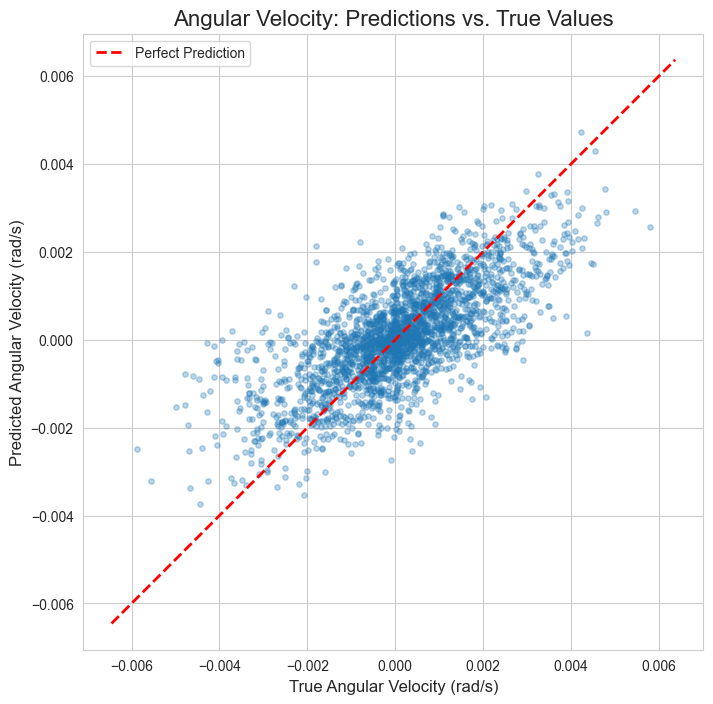

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# --- 1. Prepare Data for Angular Velocity Prediction ---

# Extract the base arrays
calcium_signal = cosmos_data[0, 0]['calcium_signal']
head_orientation = np.squeeze(cosmos_data[0, 0]['head_orientation'])
timestamps = np.squeeze(cosmos_data[0, 0]['timestamps'])

# Calculate angular velocity
delta_time = np.diff(timestamps)
delta_theta = np.diff(head_orientation)
angular_velocity = (delta_theta + np.pi) % (2 * np.pi) - np.pi
angular_velocity = angular_velocity / delta_time

# Align calcium signal with the calculated angular velocity
X = calcium_signal[1:, :] # Use [1:] to align with the N-1 length of angular_velocity
y = angular_velocity

print(f"Shape of X: {X.shape}")
print(f"Shape of y (angular_velocity): {y.shape}")

# --- Cleanse Data: Remove low-variance neurons ---
variance = np.var(X, axis=0)
low_variance_threshold = 1e-7
low_variance_indices = np.where(variance < low_variance_threshold)[0]
if len(low_variance_indices) > 0:
    print(f"⚠️ Found and removing {len(low_variance_indices)} low-variance neurons.")
    X = np.delete(X, low_variance_indices, axis=1)
print(f"Final shape of X after cleaning: {X.shape}")


# --- 2. Split and Scale Data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale input features
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

# Scale the 1D target variable
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

# Impute any potential NaNs created by the scaler
if np.isnan(X_train_scaled).any():
    print("Imputing NaNs in X_train_scaled with 0.")
    X_train_scaled = np.nan_to_num(X_train_scaled)
if np.isnan(X_test_scaled).any():
    print("Imputing NaNs in X_test_scaled with 0.")
    X_test_scaled = np.nan_to_num(X_test_scaled)

# --- 3. Prepare Data for PyTorch ---
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# --- 4. Define, Train, and Evaluate the Model ---

# Define the MLP for single-value regression
class RegressionMLP(nn.Module):
    def __init__(self, input_size):
        super(RegressionMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1) # **CHANGE**: Output layer has 1 neuron
        )
    def forward(self, x):
        return self.layers(x)

# Initialize
input_size = X_train_scaled.shape[1]
model = RegressionMLP(input_size)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Training Loop
epochs = 100
print("\n🚀 Starting model training...")
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = loss_function(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
print("✅ Training complete.")

# Evaluation
model.eval()
with torch.no_grad():
    predictions_scaled = model(X_test_tensor)
    # Inverse transform to get predictions in original units
    predictions = y_scaler.inverse_transform(predictions_scaled.numpy())
    true_values = y_scaler.inverse_transform(y_test_tensor.numpy())

    # Use R-squared for regression evaluation
    r2 = r2_score(true_values, predictions)
    print(f"\nModel Performance on Test Data:")
    print(f"R-squared (R²) Score: {r2:.3f}")

# Visualization
plt.figure(figsize=(8, 8))
sns.set_style("whitegrid")
plt.scatter(true_values, predictions, alpha=0.3, s=15)
lims = [min(plt.xlim()[0], plt.ylim()[0]), max(plt.xlim()[1], plt.ylim()[1])]
plt.plot(lims, lims, 'r--', linewidth=2, label='Perfect Prediction')
plt.title('Angular Velocity: Predictions vs. True Values', fontsize=16)
plt.xlabel('True Angular Velocity (rad/s)', fontsize=12)
plt.ylabel('Predicted Angular Velocity (rad/s)', fontsize=12)
plt.legend()
plt.axis('equal')
plt.show()

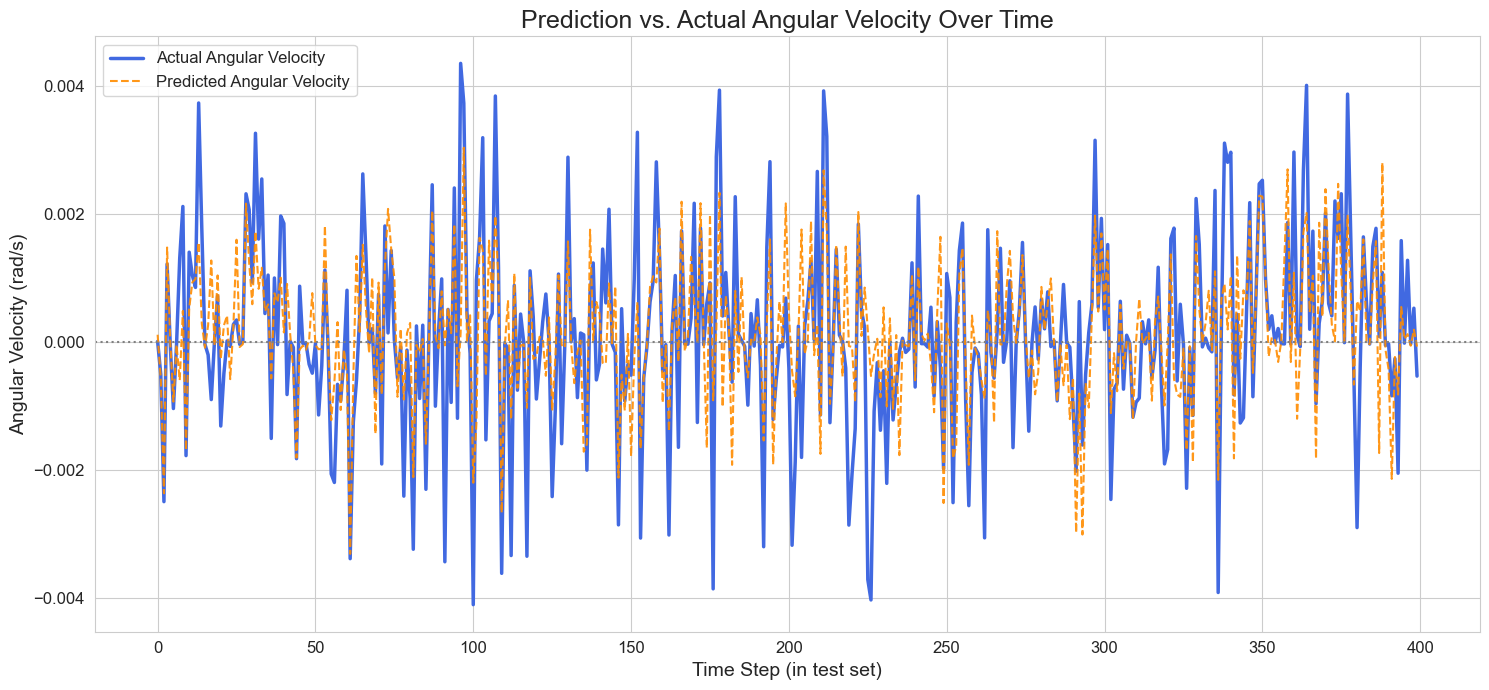

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# This cell assumes the 'model', 'X_test_tensor', and 'y_scaler'
# from the previous training step are available.

# --- 1. Generate Predictions ---
# We regenerate the predictions here to make this cell self-contained.
model.eval()
with torch.no_grad():
    predictions_scaled = model(X_test_tensor)
    # Inverse transform to get predictions in original units
    predictions = y_scaler.inverse_transform(predictions_scaled.numpy()).flatten()
    true_values = y_scaler.inverse_transform(y_test_tensor.numpy()).flatten()

# --- 2. Create the Time-Series Plot ---

# Set a plotting style and a larger figure size
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))

# Let's plot the first 400 time points of the test set for clarity
time_slice = slice(0, 400)
time_axis = np.arange(400)

# Plot the true and predicted values
plt.plot(time_axis, true_values[time_slice], label='Actual Angular Velocity', linewidth=2.5, color='royalblue')
plt.plot(time_axis, predictions[time_slice], label='Predicted Angular Velocity', linestyle='--', alpha=0.9, color='darkorange')

plt.title('Prediction vs. Actual Angular Velocity Over Time', fontsize=18)
plt.xlabel('Time Step (in test set)', fontsize=14)
plt.ylabel('Angular Velocity (rad/s)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Add a horizontal line at zero for reference
plt.axhline(y=0, color='gray', linestyle=':', linewidth=1.5)

plt.tight_layout()
plt.show()

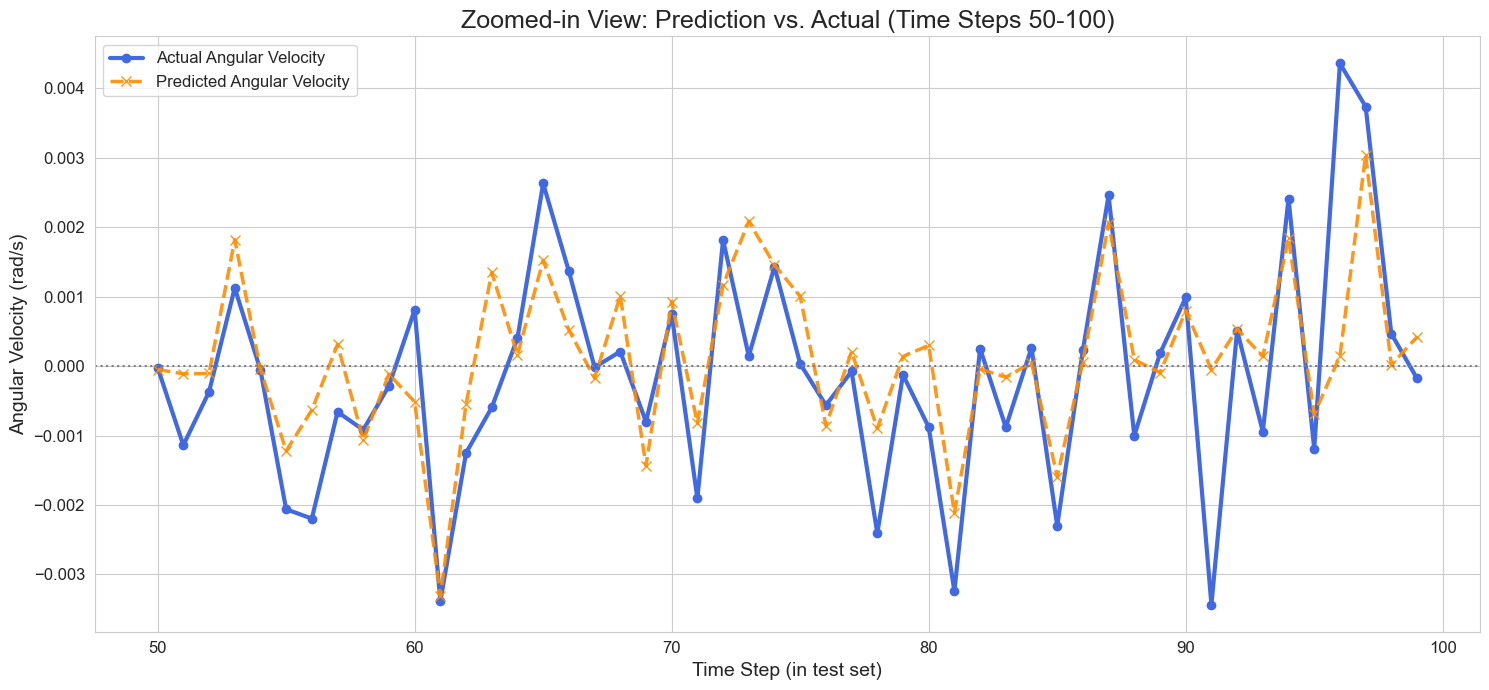

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# This cell assumes the 'model', 'X_test_tensor', and 'y_scaler'
# from the previous training step are available.

# --- 1. Generate Predictions ---
# We regenerate the predictions here to make this cell self-contained.
model.eval()
with torch.no_grad():
    predictions_scaled = model(X_test_tensor)
    # Inverse transform to get predictions in original units
    predictions = y_scaler.inverse_transform(predictions_scaled.numpy()).flatten()
    true_values = y_scaler.inverse_transform(y_test_tensor.numpy()).flatten()

# --- 2. Create the Zoomed-in Time-Series Plot ---

# Set a plotting style and a larger figure size
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))

# **THE CHANGE**: Set the time slice to the 50-100 range
time_slice = slice(50, 100)
# Adjust the time axis to match the slice
time_axis = np.arange(50, 100)

# Plot the true and predicted values for the specified slice
plt.plot(time_axis, true_values[time_slice], label='Actual Angular Velocity', linewidth=3, marker='o', markersize=6, color='royalblue')
plt.plot(time_axis, predictions[time_slice], label='Predicted Angular Velocity', linestyle='--', linewidth=2.5, marker='x', markersize=7, alpha=0.9, color='darkorange')

plt.title('Zoomed-in View: Prediction vs. Actual (Time Steps 50-100)', fontsize=18)
plt.xlabel('Time Step (in test set)', fontsize=14)
plt.ylabel('Angular Velocity (rad/s)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Add a horizontal line at zero for reference
plt.axhline(y=0, color='gray', linestyle=':', linewidth=1.5)

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# --- 1. Prepare Data for Ordinal Head Orientation Prediction ---

# Extract the base arrays
calcium_signal = cosmos_data[0, 0]['calcium_signal']
head_orientation = np.squeeze(cosmos_data[0, 0]['head_orientation'])

# Use the full, un-differenced calcium signal as input
X = calcium_signal
# The target is the head orientation itself
y_continuous = head_orientation

print(f"Initial shape of X: {X.shape}")
print(f"Initial shape of y (continuous angle): {y_continuous.shape}")

# --- 2. Bin the Angles into 8 Ordinal Categories ---
# We use pd.cut to divide the range [-pi, pi] into 8 equal bins
bins = np.linspace(-np.pi, np.pi, 9) # 9 edges for 8 bins
labels = np.arange(8) # Labels will be 0, 1, 2, ..., 7
y_binned = pd.cut(y_continuous, bins=bins, labels=labels, include_lowest=True)

# Convert to a numpy array of integers
y = y_binned.to_numpy().astype(int)

# --- 3. Cleanse Data: Remove low-variance neurons ---
variance = np.var(X, axis=0)
low_variance_threshold = 1e-7
low_variance_indices = np.where(variance < low_variance_threshold)[0]
if len(low_variance_indices) > 0:
    print(f"⚠️ Found and removing {len(low_variance_indices)} low-variance neurons.")
    X = np.delete(X, low_variance_indices, axis=1)
print(f"Final shape of X after cleaning: {X.shape}")


# --- 4. Split and Scale Data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale input features ONLY
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

# Impute any potential NaNs created by the scaler
if np.isnan(X_train_scaled).any():
    X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0)
if np.isnan(X_test_scaled).any():
    X_test_scaled = np.nan_to_num(X_test_scaled, nan=0.0)

# --- 5. Prepare Data for PyTorch ---
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# For CrossEntropyLoss, the target must be of type Long
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print("\n✅ Data is now ready for ordinal classification.")

Initial shape of X: (14278, 168)
Initial shape of y (continuous angle): (14278,)
Final shape of X after cleaning: (14278, 168)

✅ Data is now ready for ordinal classification.


/Users/stevew/.pyenv/versions/3.10.11/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:1144: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/stevew/.pyenv/versions/3.10.11/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:1149: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/stevew/.pyenv/versions/3.10.11/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/extmath.py:1169: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:
from sklearn.metrics import accuracy_score

# --- Define the MLP for Ordinal Classification ---
class OrdinalMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(OrdinalMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            # **CHANGE**: Output layer has 8 neurons for our 8 bins
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.layers(x)

# --- Initialize ---
input_size = X_train_scaled.shape[1]
num_classes = 8
model = OrdinalMLP(input_size, num_classes)
# **CHANGE**: Use CrossEntropyLoss for classification
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# --- Training Loop ---
epochs = 500
print("\n🚀 Starting model training for ordinal classification...")
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = loss_function(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
print("✅ Training complete.")

# --- Evaluation ---
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    # Get the predicted class (bin) by finding the index of the max logit
    _, predicted_bins = torch.max(outputs, 1)

    accuracy = accuracy_score(y_test_tensor.numpy(), predicted_bins.numpy())
    print(f"\nModel Performance on Test Data:")
    print(f"Accuracy: {accuracy*100:.2f}%")


🚀 Starting model training for ordinal classification...
Epoch [10/500], Loss: 1.3049
Epoch [20/500], Loss: 0.7509
Epoch [30/500], Loss: 0.7878
Epoch [40/500], Loss: 0.5904
Epoch [50/500], Loss: 0.7013
Epoch [60/500], Loss: 0.6498
Epoch [70/500], Loss: 0.8092
Epoch [80/500], Loss: 0.5137
Epoch [90/500], Loss: 0.6274
Epoch [100/500], Loss: 0.6584
Epoch [110/500], Loss: 0.4398
Epoch [120/500], Loss: 0.7870
Epoch [130/500], Loss: 0.5054
Epoch [140/500], Loss: 0.5122
Epoch [150/500], Loss: 0.9167
Epoch [160/500], Loss: 0.8952
Epoch [170/500], Loss: 0.7634
Epoch [180/500], Loss: 0.6819
Epoch [190/500], Loss: 0.8555
Epoch [200/500], Loss: 1.0134
Epoch [210/500], Loss: 0.5862
Epoch [220/500], Loss: 0.5973
Epoch [230/500], Loss: 0.5275
Epoch [240/500], Loss: 0.2503
Epoch [250/500], Loss: 0.3714
Epoch [260/500], Loss: 0.4919
Epoch [270/500], Loss: 0.3544
Epoch [280/500], Loss: 0.8133
Epoch [290/500], Loss: 0.4630
Epoch [300/500], Loss: 0.4200
Epoch [310/500], Loss: 0.4022
Epoch [320/500], Loss:

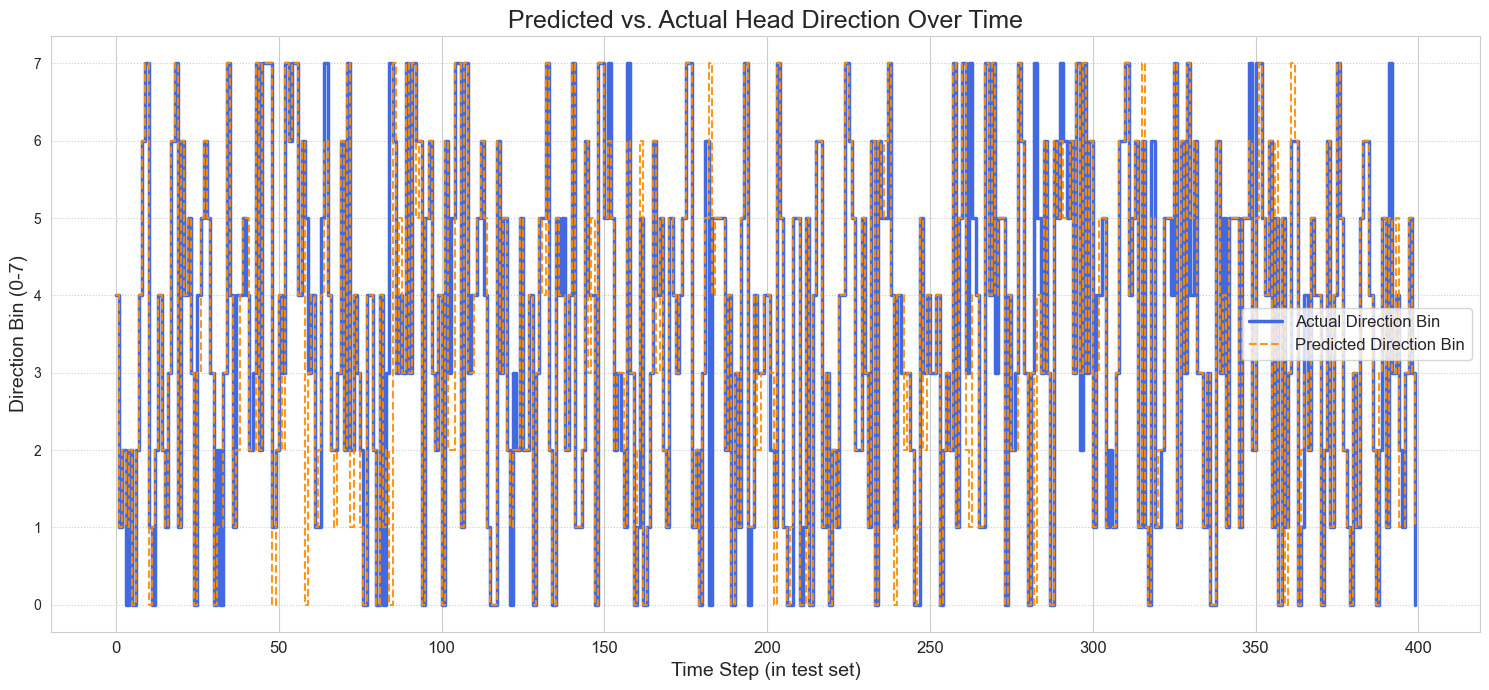

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Create the Time-Series Plot for Binned Directions ---
sns.set_style("whitegrid")
plt.figure(figsize=(15, 7))

time_slice = slice(0, 400)
time_axis = np.arange(400)

# Plot the true and predicted values
plt.plot(time_axis, y_test_tensor.numpy()[time_slice], label='Actual Direction Bin', linewidth=2.5, color='royalblue', drawstyle='steps-post')
plt.plot(time_axis, predicted_bins.numpy()[time_slice], label='Predicted Direction Bin', linestyle='--', alpha=0.9, color='darkorange', drawstyle='steps-post')

plt.title('Predicted vs. Actual Head Direction Over Time', fontsize=18)
plt.xlabel('Time Step (in test set)', fontsize=14)
plt.ylabel('Direction Bin (0-7)', fontsize=14)
plt.yticks(np.arange(8)) # Set y-ticks to be the bin numbers
plt.xticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.show()